In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.animation as animation

from torch.utils.data import Dataset
# import binvox
import os
import json
import trimesh
import skimage
import random
# from mesh_to_sdf import mesh_to_voxels, sample_sdf_near_surface, scale_to_unit_sphere
import mesh_to_sdf
import pyrender
import numpy as np
import matplotlib.pyplot as plt
import io
from deep_sdf import utils, metrics, plotting, workspace, mesh
import math
import pandas as pd
import pytorch3d
import sklearn
from sklearn.manifold import TSNE
import torch
import matplotlib
import copy
import shlex

# mpl.rcParams['font.family'] = 'Arial'

import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

/home/wulff/anaconda3/envs/deep3dcomp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plotting Network Params vs. Reconstruction Quality


<=== Reading net exps ===>
Extracting num_params=37111 width=96 depth=3 latent=200: CD_mean=0.000401 CD_median=0.000107 num_shapes=456
    -> Eval on train set: CD_mean=0.000253 CD_median=0.000095 num_shapes=500
Extracting num_params=74004 width=128 depth=4 latent=200: CD_mean=0.000242 CD_median=0.000084 num_shapes=456
    -> Eval on train set: CD_mean=0.000216 CD_median=0.000071 num_shapes=500
Extracting num_params=258934 width=192 depth=6 latent=200: CD_mean=0.000218 CD_median=0.000047 num_shapes=456
    -> Eval on train set: CD_mean=0.000119 CD_median=0.000036 num_shapes=500
Extracting num_params=557616 width=256 depth=8 latent=200: CD_mean=0.000257 CD_median=0.000045 num_shapes=456
    -> Eval on train set: CD_mean=0.000141 CD_median=0.000034 num_shapes=500
Extracting num_params=1537644 width=384 depth=12 latent=200: CD_mean=0.000268 CD_median=0.000042 num_shapes=456
    -> Eval on train set: CD_mean=0.000063 CD_median=0.000022 num_shapes=500
Extracting num_params=148180 width=192

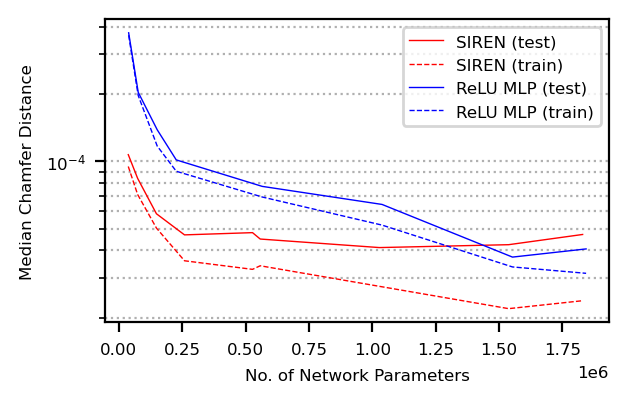

In [51]:
exps_net = [
    "../../shared/deepsdfcomp/searches/num_params_search/exp00_3layers_96width",    
    "../../shared/deepsdfcomp/searches/num_params_search/exp00_4layers_128width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp01_6layers_192width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp02_8layers_256width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp04_12layers_384width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp04.2_4layers_192width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp05_6layers_288width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp06_8layers_384width",
    # "../../shared/deepsdfcomp/searches/num_params_search/exp08_6layers_384width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp09_8layers_512width",
]
exps_net_relu = [
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp00_3layers_96width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp00_4layers_128width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp01_6layers_192width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp02_8layers_256width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp04_12layers_384width_relu",  
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp04.2_4layers_192width_relu",  
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp06_8layers_384width_relu",  
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp09_8layers_512width_relu",  
    # "../../shared/deepsdfcomp/searches/num_params_search_relu/baseline",  
    ]
plotting.plot_capacity_vs_chamfer_dist(
    exp_dirs_net_capacity = exps_net, 
    exp_dirs_net_relu_capacity = exps_net_relu,
    plot_aspect_ratios = False,
    plot_means = False,
    add_title = False,
)


<=== Reading net exps ===>
Extracting num_params=37111 width=96 depth=3 latent=200: CD_mean=0.000401 CD_median=0.000107 num_shapes=456
    -> Eval on train set: CD_mean=0.000253 CD_median=0.000095 num_shapes=500
Extracting num_params=74004 width=128 depth=4 latent=200: CD_mean=0.000242 CD_median=0.000084 num_shapes=456
    -> Eval on train set: CD_mean=0.000216 CD_median=0.000071 num_shapes=500
Extracting num_params=258934 width=192 depth=6 latent=200: CD_mean=0.000218 CD_median=0.000047 num_shapes=456
    -> Eval on train set: CD_mean=0.000119 CD_median=0.000036 num_shapes=500
Extracting num_params=557616 width=256 depth=8 latent=200: CD_mean=0.000257 CD_median=0.000045 num_shapes=456
    -> Eval on train set: CD_mean=0.000141 CD_median=0.000034 num_shapes=500
Extracting num_params=1537644 width=384 depth=12 latent=200: CD_mean=0.000268 CD_median=0.000042 num_shapes=456
    -> Eval on train set: CD_mean=0.000063 CD_median=0.000022 num_shapes=500
Extracting num_params=148180 width=192

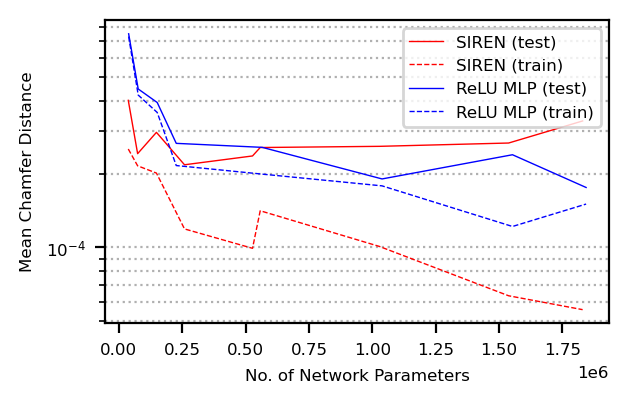

In [52]:
exps_net = [
    "../../shared/deepsdfcomp/searches/num_params_search/exp00_3layers_96width",    
    "../../shared/deepsdfcomp/searches/num_params_search/exp00_4layers_128width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp01_6layers_192width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp02_8layers_256width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp04_12layers_384width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp04.2_4layers_192width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp05_6layers_288width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp06_8layers_384width",
    # "../../shared/deepsdfcomp/searches/num_params_search/exp08_6layers_384width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp09_8layers_512width",
]
exps_net_relu = [
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp00_3layers_96width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp00_4layers_128width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp01_6layers_192width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp02_8layers_256width_relu",    
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp04_12layers_384width_relu",  
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp04.2_4layers_192width_relu",  
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp06_8layers_384width_relu",  
    "../../shared/deepsdfcomp/searches/num_params_search_relu/exp09_8layers_512width_relu",  
    # "../../shared/deepsdfcomp/searches/num_params_search_relu/baseline",  
    ]
plotting.plot_capacity_vs_chamfer_dist(
    exp_dirs_net_capacity = exps_net, 
    exp_dirs_net_relu_capacity = exps_net_relu,
    plot_aspect_ratios = False,
    plot_means = True,
    add_title = False,
)

# Plotting Latent Params vs. Reconstruction Quality


<=== Reading net exps ===>

<=== Reading net_relu exps ===>

<=== Reading lat exps ===>
Extracting num_params=461476 width=256 depth=8 latent=10: CD_mean=0.006352 CD_median=0.005542 num_shapes=456
Extracting num_params=481716 width=256 depth=8 latent=50: CD_mean=0.000978 CD_median=0.000091 num_shapes=456
Extracting num_params=507016 width=256 depth=8 latent=100: CD_mean=0.000451 CD_median=0.000052 num_shapes=456
Extracting num_params=557616 width=256 depth=8 latent=200: CD_mean=0.000257 CD_median=0.000045 num_shapes=456
Extracting num_params=585952 width=256 depth=8 latent=256: CD_mean=0.000166 CD_median=0.000032 num_shapes=456
Extracting num_params=608216 width=256 depth=8 latent=300: CD_mean=0.000235 CD_median=0.000043 num_shapes=456
Extracting num_params=709416 width=256 depth=8 latent=500: CD_mean=0.000155 CD_median=0.000040 num_shapes=456

<=== Reading vox exps ===>
Extracting vox_res=16.0: CD=0.00162 num_shapes=456
   -> num_vox=5832.0 num_sparse_voxels=2464
Extracting vox_res=3

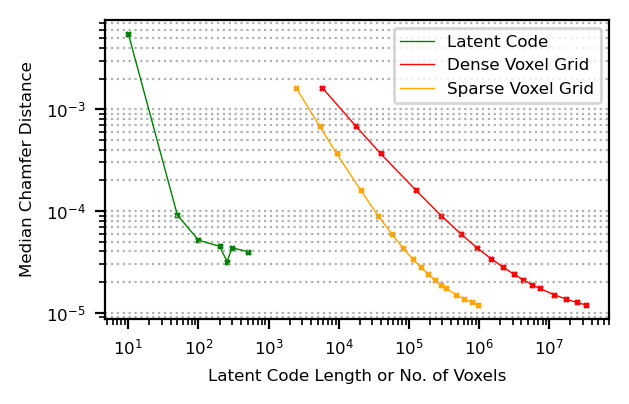

In [53]:
exps_lat = [
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_10",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_50",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_100",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_200",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_256",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_300",
    "../../shared/deepsdfcomp/searches/num_latents_search/exp_500",
]
vox_logs = [
    "data/voxelize_sdf_gen/vox_res=16/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=32/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=24/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=48/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=64/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=80/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=96/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=112/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=128/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=144/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=160/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=176/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=192/run_voxelize_logs.csv",
    # "data/voxelize_sdf_gen/vox_res=208/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=224/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=256/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=288/run_voxelize_logs.csv",
    "data/voxelize_sdf_gen/vox_res=320/run_voxelize_logs.csv",
]
plotting.plot_capacity_vs_chamfer_dist(
    exp_dirs_lat_capacity = exps_lat, 
    voxelization_logs= vox_logs,
    plot_aspect_ratios = False,
    plot_means = False,
    add_title = False,
)

In [42]:
967126.2061403509 / 33386248.0

0.028967801537338096

In [44]:
2464.3530701754385 / 5832.0

0.42255711079825764

In [45]:
147351.93640350876 / 256

575.5935015762061

# Visualizing Example Reconstructions

Saving .png to reconstruction_comparison.pdf


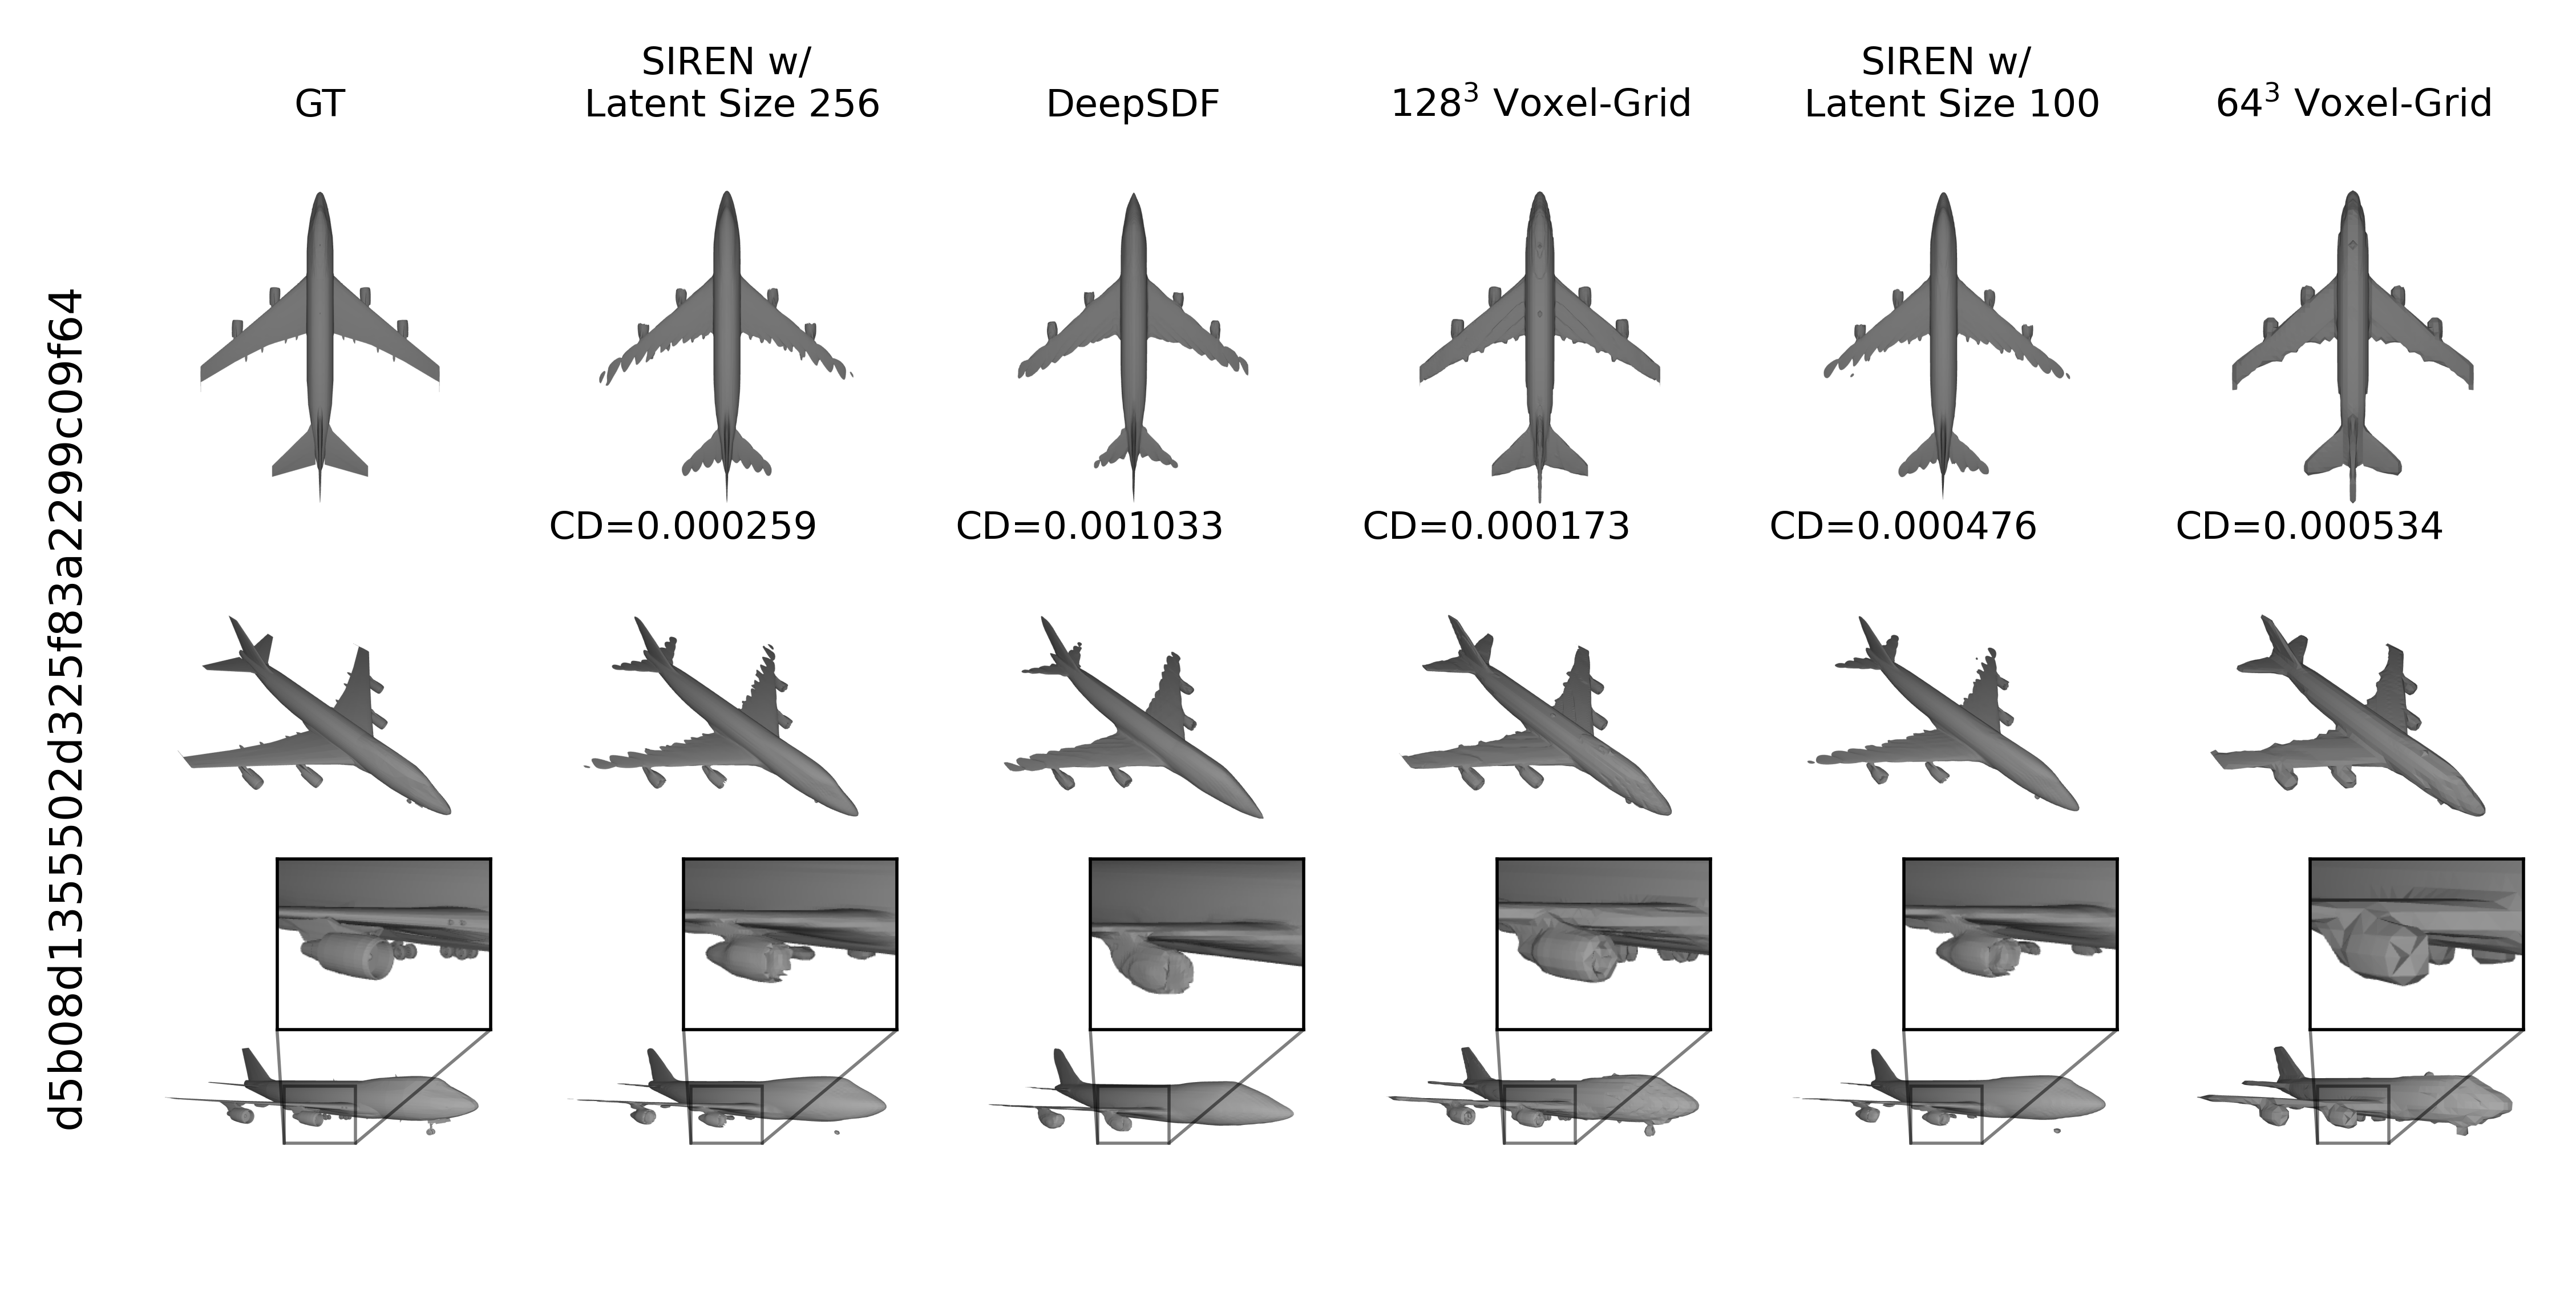

In [65]:
exps = {
    "SIREN w/\n Latent Size 256": "../../shared/deepsdfcomp/searches/num_latents_search/exp_256",
    "DeepSDF": "../../shared/deepsdfcomp/searches/num_params_search/baseline",
    "$128^3$ Voxel-Grid": "data/voxelize_sdf_gen/vox_res=128",
    "SIREN w/\n Latent Size 100": "../../shared/deepsdfcomp/searches/num_latents_search/exp_100",
    "$64^3$ Voxel-Grid": "data/voxelize_sdf_gen/vox_res=64",    
}
shape_ids = [
    "d5b08d1355502d325f83a2299c09f64",
]
inset_xxyy = [
    (400, 600, 320, 480),
]

plotting.plot_reconstruction_comparison(
    exps, 
    shape_ids, 
    no_axes_ticks=True, 
    inset_xxyy=inset_xxyy, 
    inset_zoom_xywh=[0.98-0.6, 0.98-0.4, 0.6, 0.6],
    repeat_titles = False,
    dpi = 800,
)

## More Shapes

Saving .png to reconstruction_comparison_success.pdf


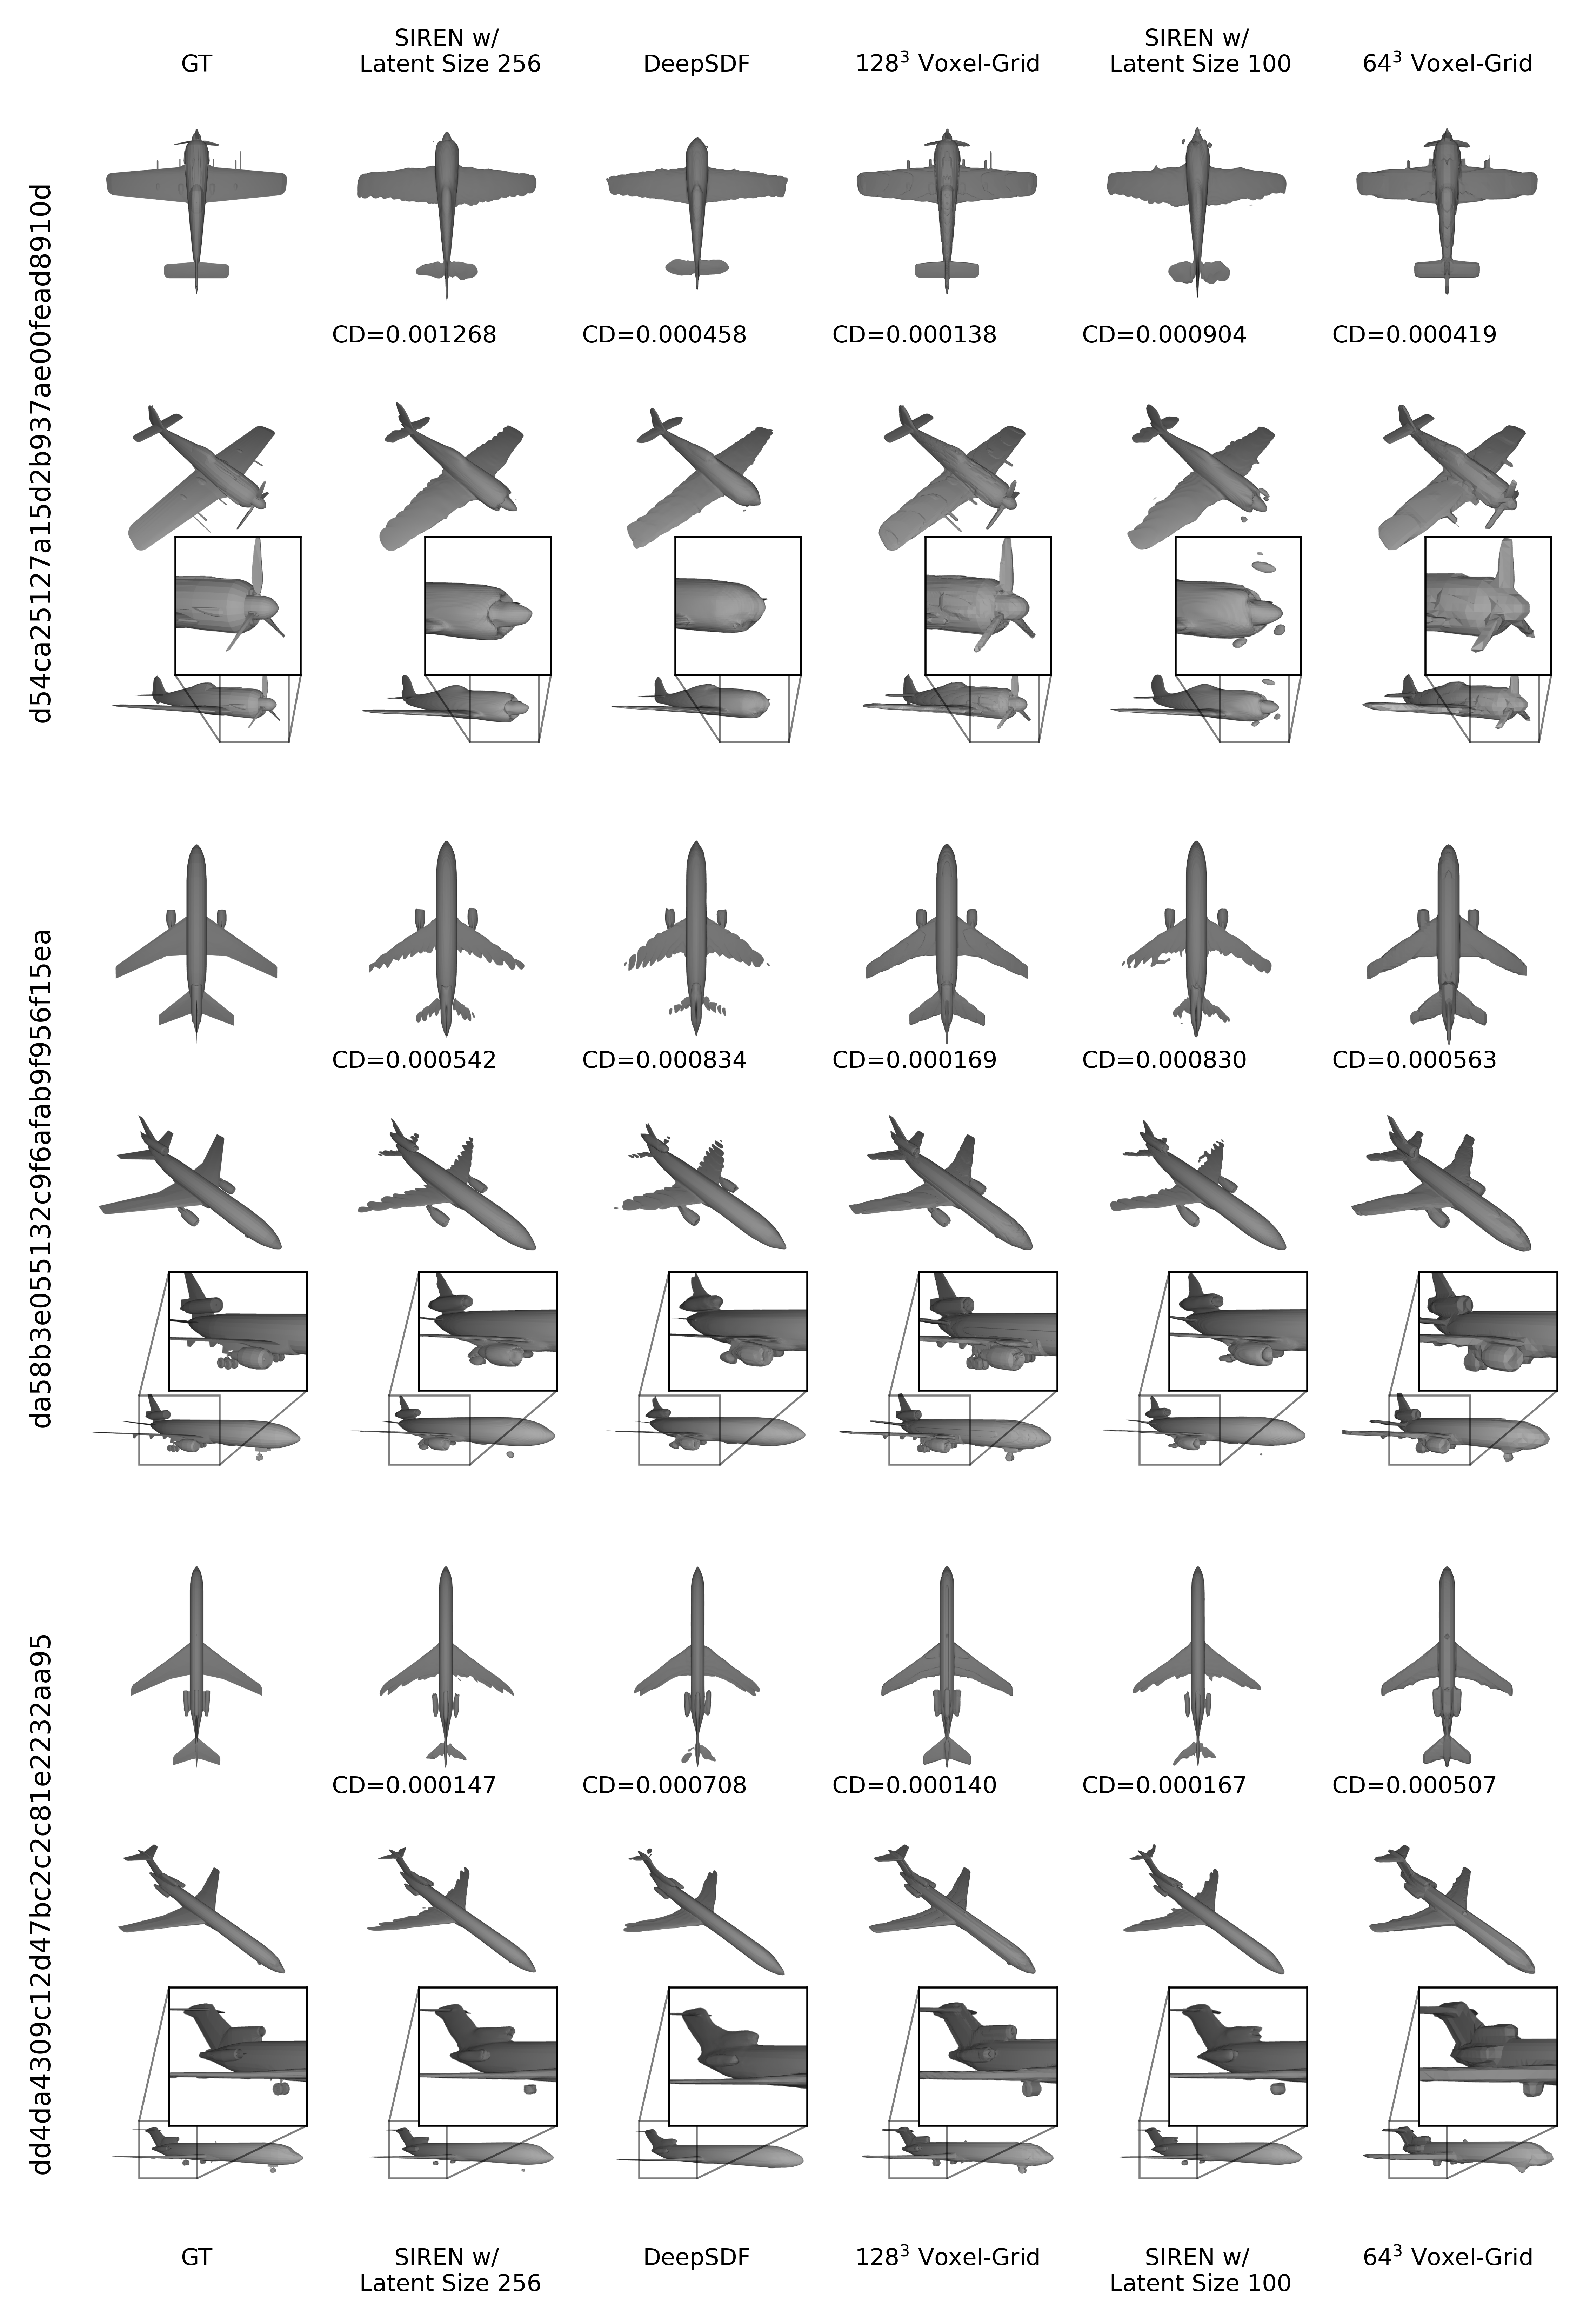

In [74]:
exps = {
    "SIREN w/\n Latent Size 256": "../../shared/deepsdfcomp/searches/num_latents_search/exp_256",
    "DeepSDF": "../../shared/deepsdfcomp/searches/num_params_search/baseline",
    "$128^3$ Voxel-Grid": "data/voxelize_sdf_gen/vox_res=128",
    "SIREN w/\n Latent Size 100": "../../shared/deepsdfcomp/searches/num_latents_search/exp_100",
    "$64^3$ Voxel-Grid": "data/voxelize_sdf_gen/vox_res=64",    
}
shape_ids = [
    "d54ca25127a15d2b937ae00fead8910d",
    "da58b3e055132c9f6afab9f956f15ea",
    "dd4da4309c12d47bc2c2c81e2232aa95",
]
inset_xxyy = [
    (600, 900, 290, 620),
    (250, 600, 300, 600),
    (250, 500, 350, 600),
]

plotting.plot_reconstruction_comparison(
    exps, 
    shape_ids, 
    no_axes_ticks=True, 
    inset_xxyy=inset_xxyy, 
    inset_zoom_xywh=[0.98-0.6, 0.98-0.4, 0.6, 0.6],
    repeat_titles = True,
    dpi = 800,
    suffix = "success",
)

## Failure Cases

Saving .png to reconstruction_comparison_failure.pdf


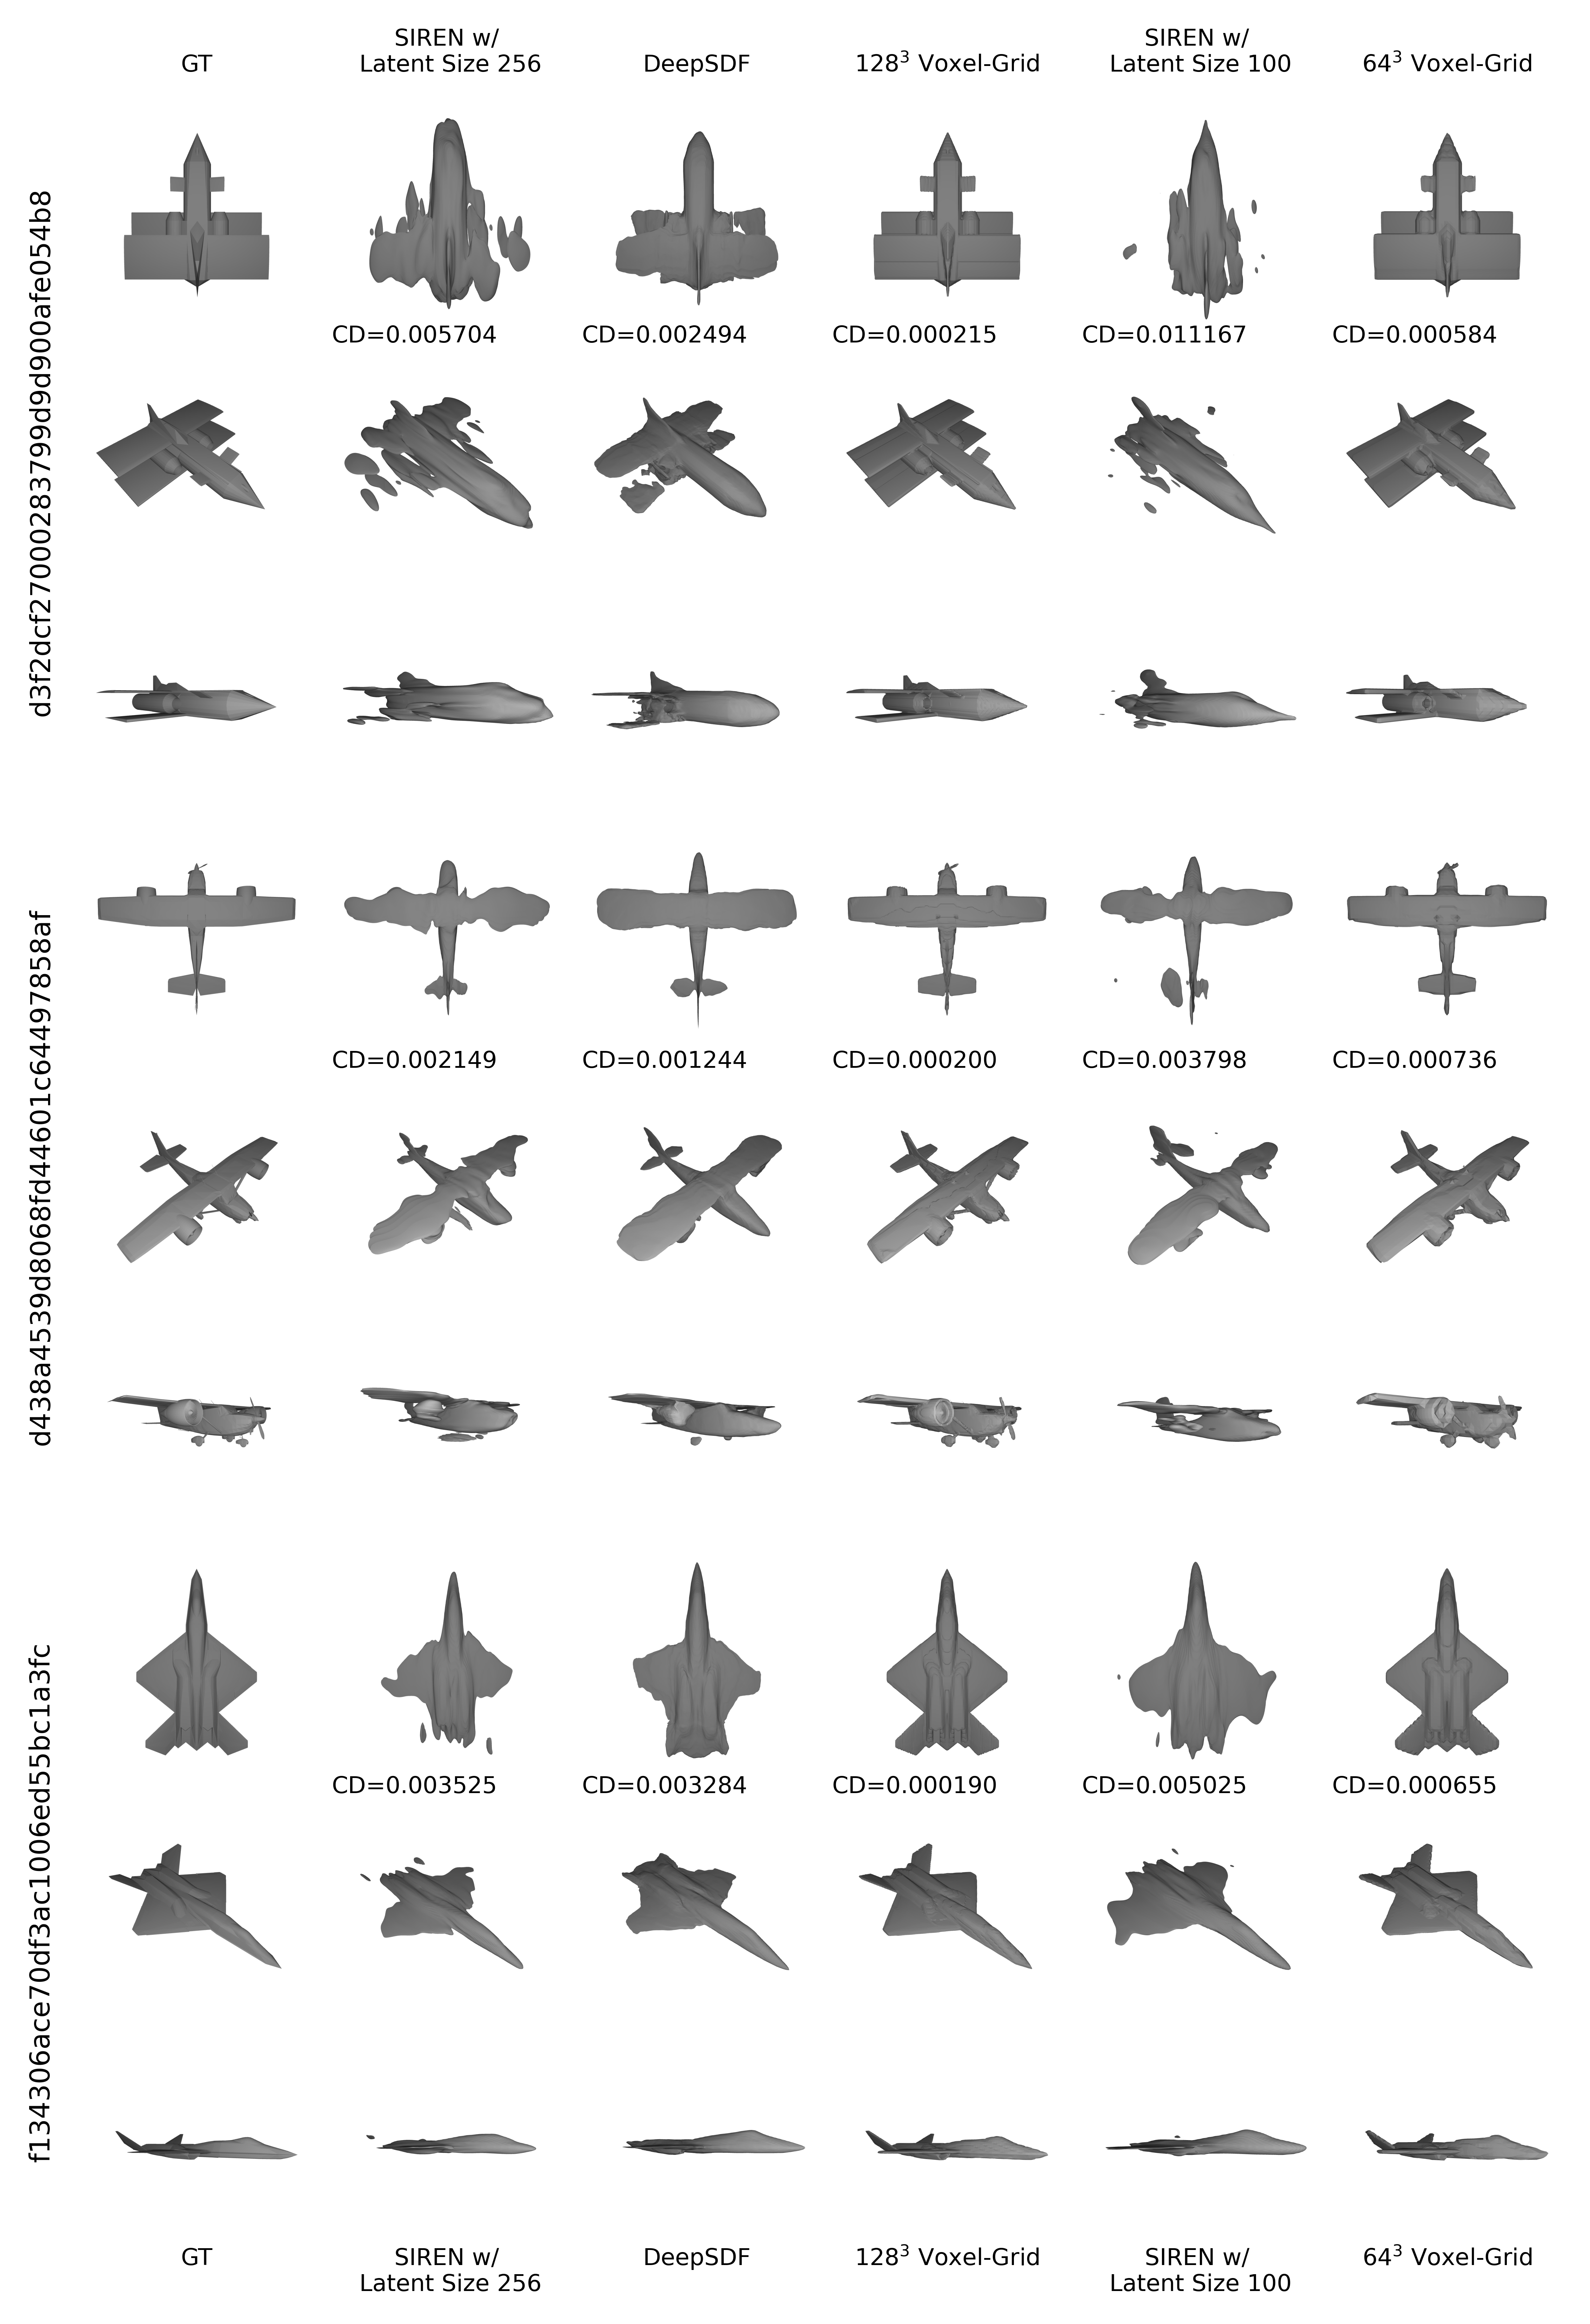

In [75]:
exps = {
    "SIREN w/\n Latent Size 256": "../../shared/deepsdfcomp/searches/num_latents_search/exp_256",
    "DeepSDF": "../../shared/deepsdfcomp/searches/num_params_search/baseline",
    "$128^3$ Voxel-Grid": "data/voxelize_sdf_gen/vox_res=128",
    "SIREN w/\n Latent Size 100": "../../shared/deepsdfcomp/searches/num_latents_search/exp_100",
    "$64^3$ Voxel-Grid": "data/voxelize_sdf_gen/vox_res=64",    
}
shape_ids = [
    "d3f2dcf27000283799d9d900afe054b8",
    "d438a4539d8068fd44601c64497858af",
    "f134306ace70df3ac1006ed55bc1a3fc",   # figther jet -> failure case
]
inset_xxyy = [
    # (400, 600, 320, 480),
    # (180, 340, 260, 370),
]

plotting.plot_reconstruction_comparison(
    exps, 
    shape_ids, 
    no_axes_ticks=True, 
    inset_xxyy=inset_xxyy, 
    inset_zoom_xywh=[0.98-0.6, 0.98-0.4, 0.6, 0.6],
    repeat_titles = True,
    dpi = 800,
    suffix = "failure",
)

# t-SNE of the Manifold

In [4]:
plotting.plot_manifold_tsne("../../shared/deepsdfcomp/searches/num_latents_search/exp_256")

FileNotFoundError: [Errno 2] No such file or directory: '/home/florian_wulff_4/Deep3DComp/examples/splits/sv2_planes_train.json'

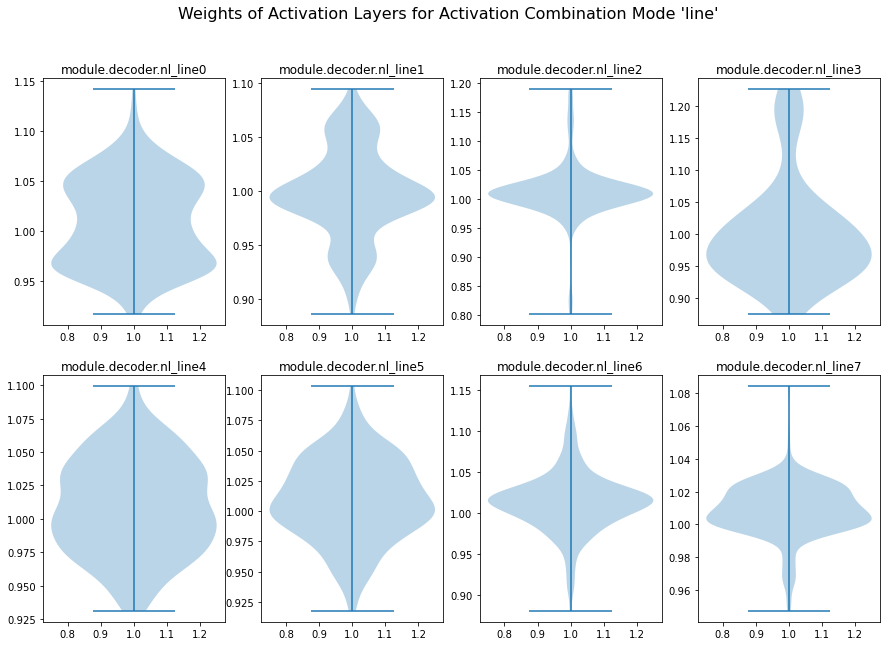

In [32]:
import torch
from matplotlib import pyplot as plt
chckpt = torch.load("/home/shared/deepsdfcomp/searches/double_nonlinearity/line/ModelParameters/latest.pth")
fig, axes = plt.subplots(2, 4, figsize=(15,10))
fig.suptitle("Weights of Activation Layers for Activation Combination Mode 'line'", fontsize=16)
for i, (k,v) in enumerate([(kk, vv) for kk, vv in chckpt["model_state_dict"].items() if "nl_line" in kk][:8]):
    ax = axes[i//4,i%4]
    ax.set_title(k)
    vplot = ax.violinplot(v.detach().cpu().numpy(), showmeans=False, showextrema=True)
plt.show()

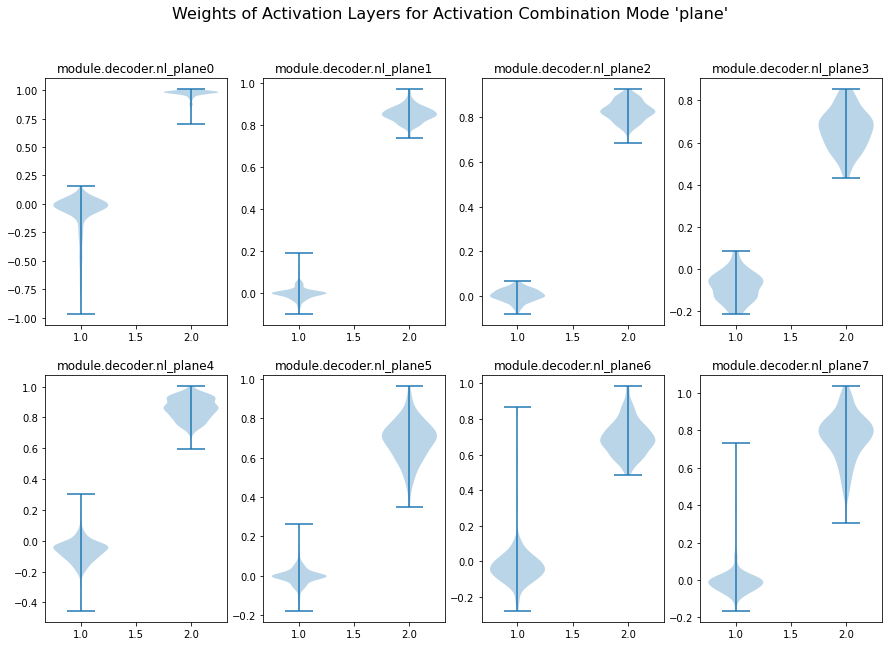

In [39]:
import torch
from matplotlib import pyplot as plt
chckpt = torch.load("/home/shared/deepsdfcomp/searches/double_nonlinearity/plane/ModelParameters/latest.pth")
fig, axes = plt.subplots(2, 4, figsize=(15,10))
fig.suptitle("Weights of Activation Layers for Activation Combination Mode 'plane'", fontsize=16)
for i, (k,v) in enumerate([(kk, vv) for kk, vv in chckpt["model_state_dict"].items() if "nl_plane" in kk][:8]):
    ax = axes[i//4,i%4]
    ax.set_title(k)
    vplot = ax.violinplot(v.detach().cpu().numpy(), showmeans=False, showextrema=True)
plt.show()

In [4]:
import pandas as pd
data = pd.read_csv("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer.csv", delimiter=';')
print(f"{data['chamfer_dist'].mean():5f}, {data['chamfer_dist'].median():5f}")

0.083380, 0.083885


In [ ]:
python reconstruct.py  --split ../../shared/deepsdfcomp/experiments/splits/sv2_planes_test.json -d ../../shared/deepsdfcomp/data/ -e ../../shared/deepsdfcomp/searches/double_nonlinearity/line --skip
python evaluate.py  --split ../../shared/deepsdfcomp/experiments/splits/sv2_planes_test.json -d ../../shared/deepsdfcomp/data/ -e ../../shared/deepsdfcomp/searches/double_nonlinearity/line -c 2000

9

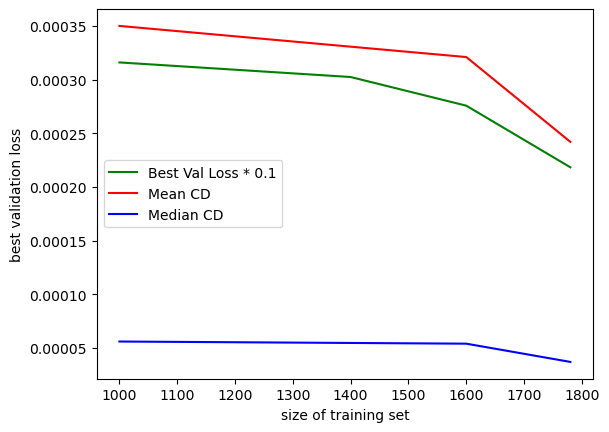

In [20]:
import numpy as np
from matplotlib import pyplot as plt
set_sizes = np.array([1780, 1600, 1400, 1200, 1000, 600, 200])
val_losses = np.array([2.183e-3, 2.757e-3, 3.024e-3, np.nan, 3.16e-3, np.nan, np.nan])
mean_CDs = np.array([0.242e-3, 0.321e-3, np.nan, np.nan, 0.350e-3, np.nan, np.nan])
median_CDs = np.array([0.037e-3, 0.054e-3, np.nan, np.nan, 0.056e-3, np.nan, np.nan])

plt.plot(set_sizes[np.isfinite(val_losses)], val_losses[np.isfinite(val_losses)]*0.1, 'g', label="Best Val Loss * 0.1")
plt.plot(set_sizes[np.isfinite(mean_CDs)], mean_CDs[np.isfinite(mean_CDs)], 'r', label="Mean CD")
plt.plot(set_sizes[np.isfinite(median_CDs)], median_CDs[np.isfinite(median_CDs)], 'b', label="Median CD")
plt.xlabel("size of training set")
plt.ylabel("best validation loss")
plt.legend()

In [21]:
import json
import random
import copy
import os
path = "/home/shared/deepsdfcomp/searches/splits/"
fname = "sv2_planes_train"
with open(os.path.join(path, fname + ".json"), 'r') as f:
    all_shapes_dict = json.load(f)
split_sizes = [1780, 1600, 1400, 1200, 1000, 800, 600, 400, 200]
for split_size in split_sizes:
    split = copy.deepcopy(all_shapes_dict)
    sampled_list = random.shuffle(split["ShapeNetV2"]["02691156"])
    split["ShapeNetV2"]["02691156"] = split["ShapeNetV2"]["02691156"][:split_size]
    with open(os.path.join(path, "subsamples", f"{fname} _{split_size}.json"), 'w+') as f:
        json.dump(split, f, indent=4)

"baseline"
	Curvature Sampling: 0 % 
	Mean CD: 1.467e-04
	Median CD: 4.003e-05
	Best Meshes:
		fdcb11fa39661f0fb08f81d66e854bfa with CD of 1.1679990103997374e-06
		df411aa240fe48d5855eb7906a7a7a04 with CD of 1.6090262747775775e-06
		d28a3cd771b2bf1e71d03b466c72ce41 with CD of 8.657810973807102e-06
	Worst Meshes:
		e3f562bd552fbb14496e2f80fb255499 with CD of 0.0101094990308915
		fc16704314dc71ee9a6e43b878d5b335 with CD of 0.00358775584537
		d8a037897d5d5b108130971b27e95927 with CD of 0.0029784317984686
"siren_w256"
	Curvature Sampling: 0 % 
	Mean CD: 1.786e-04
	Median CD: 3.215e-05
	Best Meshes:
		fdcb11fa39661f0fb08f81d66e854bfa with CD of 9.942681180843752e-07
		df411aa240fe48d5855eb7906a7a7a04 with CD of 2.100116248861366e-06
		df1c68e94259c6cf5c7319b71bdce6e with CD of 7.015171780932786e-06
	Worst Meshes:
		fc16704314dc71ee9a6e43b878d5b335 with CD of 0.0087567936615533
		f6e6fd724a9eab24ba8e93696257b3fc with CD of 0.0053444610768455
		fef1c15a5db21b00a67cc8f661e7890a with CD of 0.00

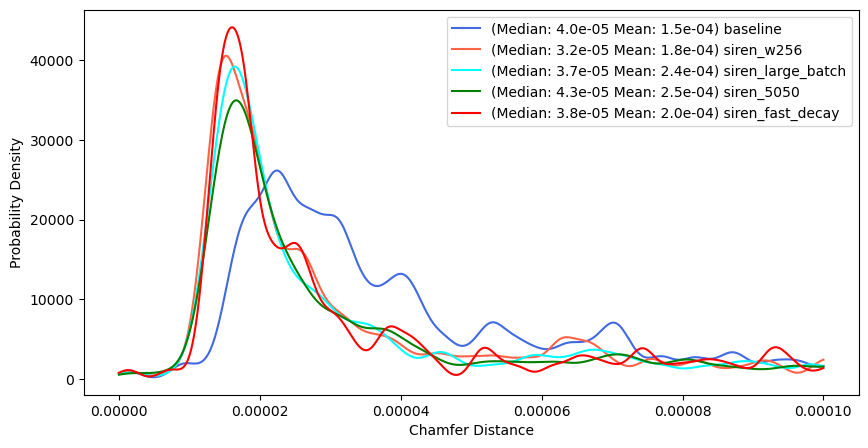

In [6]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
experiments = [
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer.csv", "baseline", "royalblue"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.200.csv", "baseline", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.300.csv", "baseline", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.500.csv", "baseline", "cyan"),
                # ("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_1.000.csv", "baseline", "lightskyblue"),
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer.csv", "siren_w256", "tomato"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.200.csv", "siren_w256", "cyan"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.300.csv", "siren_w256", "cyan"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.500.csv", "siren_w256", "cyan"), # best
                # ("/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_1.000.csv", "siren_w256", "lightsalmon"), # best
                ( "/home/shared/deepsdfcomp/searches/num_shapes_search/all_shapes_batch_size_128/Evaluation/2000/chamfer.csv", "siren_large_batch", "cyan"),
                ( "/home/shared/deepsdfcomp/searches/double_nonlinearity/line_5050_ini/Evaluation/2000/chamfer.csv", "siren_5050", "green"),
                ( "/home/shared/deepsdfcomp/searches/double_nonlinearity/all_latentsize=200_width=256_lr=5e-4_int=150/Evaluation/2000/chamfer.csv", "siren_fast_decay", "red"),
            ]

plt.figure(figsize=(10,5))
for csv_path, exp_name, color in experiments:
    CDs = pd.read_csv(csv_path, sep=";")
    # plt.hist(CDs, np.linspace(0, 0.002, 2000), alpha=1/len(csv_paths), label=csv_path.split("/")[-1])
    
    median = CDs["chamfer_dist"].median()
    mean = CDs["chamfer_dist"].mean()
    density = gaussian_kde(CDs["chamfer_dist"])
    density.covariance_factor = lambda : .003
    density._compute_covariance()
    x = np.linspace(0, 0.0001, 500)
    densities = density(x)
    
    # find best and worst meshes
    n = 3
    best_df= CDs.nsmallest(n, columns=["chamfer_dist"])
    worst_df= CDs.nlargest(n, columns=["chamfer_dist"])
    best_meshes = [mesh.split("/")[-1] for mesh in list(best_df["shape"])]
    best_mesh_cds = list(best_df["chamfer_dist"])
    worst_meshes = [mesh.split("/")[-1] for mesh in list(worst_df["shape"])]
    worst_mesh_cds = list(worst_df["chamfer_dist"])
    
    
    curvature = "0.000" if "chamfer_" not in csv_path else csv_path.split("_")[-1].split(".csv")[0]
    plt.plot(x, densities, label=f"(Median: {median:.1e} Mean: {mean:.1e}) {exp_name}", color=color)
    print(f'"{exp_name}"')
    print(f"\tCurvature Sampling: {int(float(curvature) * 100)} % ")
    print(f"\tMean CD: {np.mean(CDs['chamfer_dist']):.3e}")
    print(f"\tMedian CD: {np.median(CDs['chamfer_dist']):.3e}")
    print(f"\tBest Meshes:")
    for bm, cd in zip(best_meshes, best_mesh_cds):
        print(f"\t\t{bm} with CD of {cd}")
    print(f"\tWorst Meshes:")
    for wm, cd in zip(worst_meshes, worst_mesh_cds):
        print(f"\t\t{wm} with CD of {cd}")
plt.legend()
_ = plt.xlabel("Chamfer Distance")
_ = plt.ylabel("Probability Density")


In [1]:
import trimesh
import os
import json
mesh_name = "d3b9114df1d8a3388e415c6cf89025f0"
mesh = trimesh.load(os.path.join("/mnt/hdd/ShapeNetCore.v2/02691156", mesh_name, "models/model_normalized.obj"))
with open(os.path.join("/mnt/hdd/ShapeNetCore.v2/02691156", mesh_name, "models/model_normalized.json"), 'r') as f:
    properties = json.load(f)
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(mesh.dump())
print(mesh.vertices.min(axis=0), mesh.vertices.max(axis=0))

surface_samples = trimesh.load(os.path.join("/home/shared/deepsdfcomp/data/SurfaceSamples/ShapeNetV2/02691156", mesh_name + ".ply"))
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(surface_samples.dump())
print(surface_samples.vertices.min(axis=0), surface_samples.vertices.max(axis=0))

reco = trimesh.load(os.path.join("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Reconstructions/2000/Meshes/ShapeNetV2/02691156", mesh_name + ".ply"))
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(reco.dump())
print(reco.vertices.min(axis=0), reco.vertices.max(axis=0))


# samples = np.load()
# samples = samples[samples.files[0]]
# print(samples.min(axis=0), samples.max(axis=0)) 

concatenating texture: may result in visual artifacts


[-0.285115 -0.075618 -0.36779 ] [0.285099 0.19598  0.40751 ]
[-0.285115   -0.0755929  -0.36055401] [0.285099   0.19592801 0.40506601]
[-0.68753284 -0.31896016 -0.7864542 ] [0.68319559 0.30436653 0.88733315]


'pos'